In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATADIR = os.path.join("data", "auto-insurance-fall-2017")

## Preprocessing

Preview the training data and preprocess it so that it can be used with various classification models.

In [2]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

### 1. Data overview

In [3]:
ds = pd.read_csv(os.path.join(DATADIR, "train_auto.csv"))
ds.head()

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,1,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,...,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
1,2,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",...,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
2,4,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",...,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
3,5,0,0.0,0,51.0,0,14.0,NaN,No,"$306,251",...,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
4,6,0,0.0,0,50.0,0,NaN,"$114,986",No,"$243,925",...,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


In [4]:
# Check for NaNs / missing values:
print("Missing values count:")
ds.shape[0] - ds.count()

Missing values count:


INDEX            0
TARGET_FLAG      0
TARGET_AMT       0
KIDSDRIV         0
AGE              6
HOMEKIDS         0
YOJ            454
INCOME         445
PARENT1          0
HOME_VAL       464
MSTATUS          0
SEX              0
EDUCATION        0
JOB            526
TRAVTIME         0
CAR_USE          0
BLUEBOOK         0
TIF              0
CAR_TYPE         0
RED_CAR          0
OLDCLAIM         0
CLM_FREQ         0
REVOKED          0
MVR_PTS          0
CAR_AGE        510
URBANICITY       0
dtype: int64

### 2. Data clean-up and encoding

Some features are not numerical and thus a proper encoding must be chosen:
- for boolean features a simple {0, 1} encoding works,
- for categorical features, if a natural ordering exists (e.g. for 'EDUCATION') we simply use an ordinal encoding, otherwise we chose to use one-hot encoding as there are not too many features falling in this case and their number of categories is small compared to the number of samples.

Missing values must be filled in:
- for numerical data, we can use the mean calculated across non-missing values (this will be done after having rescaled the data),
- for categorical data we can treat missing data as an "Unknown" category.

In [5]:
# Wrap the preprocessing in a function so we can apply the same procedure to the 
# test dataset later on.
def preprocess(ds: pd.DataFrame) -> pd.DataFrame:
    """ Preprocess the dataset: clean the data and encode non-numerical features. """
    # Group features by type of data
    numeric_cols = ["KIDSDRIV", "AGE", "HOMEKIDS", "YOJ", "INCOME", "HOME_VAL",
                    "TRAVTIME", "BLUEBOOK", "TIF", "OLDCLAIM", "CLM_FREQ", 
                    "MVR_PTS", "CAR_AGE"] # numerical data
    bool_cols = ["PARENT1", "MSTATUS", "SEX", "URBANICITY", "CAR_USE", "REVOKED", "RED_CAR"] # boolean data
    cat_cols = ["EDUCATION", "JOB", "CAR_TYPE"] # categorical data
    unused_cols = ["INDEX", "TARGET_AMT"] # unused features

    clean = ds.copy()
    clean.drop(unused_cols, axis="columns", inplace=True) # remove unused features

    # Remove currency on numerics
    clean[numeric_cols] = clean[numeric_cols].replace("[\$,]", "", regex=True)
    # Convert numerics to floating point
    clean[numeric_cols] = clean[numeric_cols].astype(float)

    # Replace boolean categories by {0, 1} labels
    clean = pd.concat((clean, pd.get_dummies(clean[bool_cols], drop_first=True)), axis="columns")
    # Remove original boolean features columns
    clean.drop(bool_cols, axis="columns", inplace=True)
    
    # 'Education' can be represented with an ordinal encoding:
    oe = OrdinalEncoder(categories=[["<High School", "z_High School", "Bachelors", "Masters", "PhD"]])
    clean["EDUCATION"] = oe.fit_transform(clean[["EDUCATION"]])

    # 'JOB' has missing values: replace with "Unknown"
    clean["JOB"].fillna("Unknown", inplace=True)

    # Replace remaining categorical features by a one-hot encoding (0 and 1 labels)
    clean = pd.concat((clean, pd.get_dummies(clean[["JOB", "CAR_TYPE"]], drop_first=True)), axis="columns")
    # Remove original columns
    clean.drop(["JOB", "CAR_TYPE"], axis="columns", inplace=True)

    return clean

clean = preprocess(ds)

### 3. Scaling

Different features have widely different orders of magnitude, so we rescale each feature to have zero mean and unit variance. The scaling transformation is computed only on the samples that will be used for fitting the models, not the ones used for evaluating model performance. 

In [6]:
X = clean.drop("TARGET_FLAG", axis="columns").to_numpy() # features
y = clean["TARGET_FLAG"].to_numpy() # labels

# Split the dataset between a train and test set used to validate model performance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0, stratify=y)

# Normalize each feature
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# the standard scaler ignores NaNs. We replace NaNs by the mean value of each feature
# which is now 0 since we centered the data.
X_train = np.nan_to_num(X_train, nan=0.0)
X_test = np.nan_to_num(X_test, nan=0.0)

n_samples = X.shape[0]
n_features = X.shape[1]
print(f"{n_samples} samples, {n_features} features")

8161 samples, 34 features


## Looking for obvious solutions and visualization with PCA

Before exploring different models, we perform principal component analysis to check if a few particular directions in the feature space could explain most of the variance in the data and help simplify further analysis.

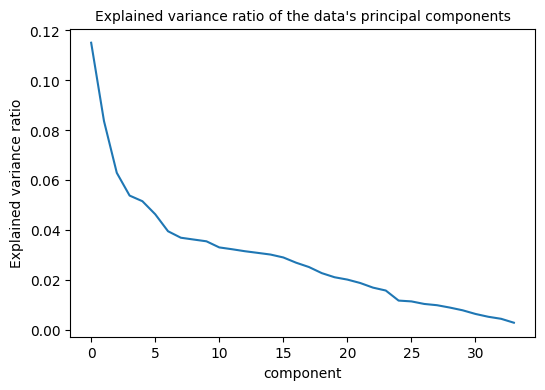

In [7]:
pca = PCA(svd_solver="full", random_state=0)
pca.fit(X_train)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(pca.explained_variance_ratio_)
ax.set_xlabel("component")
ax.set_ylabel("Explained variance ratio")
ax.set_title("Explained variance ratio of the data's principal components", fontsize=10)
plt.show()

Through PCA we see that although all components do not explain the same share of the total variance, there is no obvious threshold on the explained variance ratio that could allow us to reduce the dimensionality of the data without losing too much information. Visualizing the data projected on the firsts principal components, we see no clear separation between the two target classes.

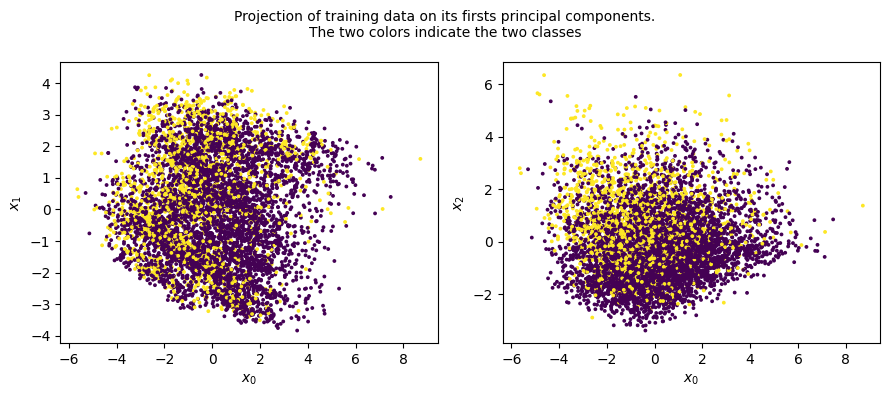

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
(ax0, ax1) = axs

X_reproj = pca.transform(X_train)
ax0.scatter(X_reproj[:,0], X_reproj[:,1], c=y_train, s=3)
ax0.set_ylabel(r"$x_1$")
ax1.scatter(X_reproj[:,0], X_reproj[:,2], c=y_train, s=3)
ax1.set_ylabel(r"$x_2$")

for ax in axs:
    ax.set_xlabel(r"$x_0$")

fig.suptitle("Projection of training data on its firsts principal components.\nThe two colors indicate the two classes", fontsize=10)
plt.tight_layout()
plt.show()

## Choosing the metric

Looking at the data labels we see that **the data is significantly imbalanced**: only about 26% of samples are positive. This means that accuracy (proportion of correctly predicted samples) will not be a good indicator of model performance. Therefore we will rather use **precision** (proportion of positive predictions that are correct) and **recall** (proportion of positive samples that are correctly detected) to evaluate our models. 

Depending on the application of the classification task we might want to give more importance to precision (if we value a low number of false positives) or recall (if we value a robust detection of positive samples). In the absence of such information we can use the harmonic mean of precision and recall, i.e. the **f1 score** as our metric to evaluate model performance.

In [9]:
print(f"Share of positive labels: {np.sum(y) / len(y):.2f}")

Share of positive labels: 0.26


## Fitting models

In the following we evaluate the performance of a few models adapted to this binary classification task (SVM, k-nearest neighbours, Random Forest, Multi-Layer Perceptron). We use grid search to find a decent set of parameters combined with cross-validation to ensure that our performance evaluation is not biased by the choice of the test set. Final model performance is measured on the left out validation test set defined earlier.

In [10]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

### 1. SVM

In [11]:
# Parameter search space: explore different kernels, regularization strengths and kernel coefficients. 
params = [{'kernel':["linear"], 'C':[1, 10, 100]}, 
          {'kernel':["rbf"], 'C':[1, 10, 100], 'gamma':[.1 / n_features, 1 / n_features, 10 / n_features]}]

# Classifier instance
svc = SVC(random_state=0, class_weight="balanced") # fix the random state to get reproducible results, 
                                                    # and account for class imbalance in the regularization parameter 'C'

# Full pipeline: cross-validated grid search on the above parameters
svc_clf = GridSearchCV(svc, params, scoring=["precision", "recall", "f1"], refit="f1", n_jobs=-1)
svc_clf.fit(X_train, y_train)

print("Best parameters:", svc_clf.best_params_)
y_pred = svc_clf.predict(X_test)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print(f"Precision: {prec:.2f}, Recall: {rec:.2f}, F-score: {f1:.2f}")

Best parameters: {'C': 10, 'gamma': 0.0029411764705882353, 'kernel': 'rbf'}
Precision: 0.48, Recall: 0.76, F-score: 0.59


This SVM classifier has a quite poor precision but good recall: about half of the positive predictions are not real positives but most of the real positive samples are detected.

### 2. KNN

In [12]:
# Parameter search space: explore different number of neighbours. 
params = {'n_neighbors': list(range(1, 20))}

# Full pipeline: cross-validated grid search on the above parameters
knn_clf = GridSearchCV(KNeighborsClassifier(), params, scoring=["precision", "recall", "f1"], refit="f1", n_jobs=-1)
knn_clf.fit(X_train, y_train)

print("Best parameters:", knn_clf.best_params_)
y_pred = knn_clf.predict(X_test)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print(f"Precision: {prec:.2f}, Recall: {rec:.2f}, F-score: {f1:.2f}")

Best parameters: {'n_neighbors': 3}
Precision: 0.51, Recall: 0.41, F-score: 0.46


The KNN classifier achieves a lower F-score than the SVM but precision and recall are more balanced.

### 3. Random forest

In [13]:
# Parameter search space: explore different maximum tree depths and split loss criterions
params = {'max_depth': list(range(5, 20)), 'criterion': ["gini", "entropy"]}

# Classifier instance
rfc = RandomForestClassifier(random_state=0) # fix the random state to get reproducible results

# Full pipeline: cross-validated grid search on the above parameters
rfc_clf = GridSearchCV(rfc, params, scoring=["precision", "recall", "f1"], refit="f1", n_jobs=-1)
rfc_clf.fit(X_train, y_train)

print("Best parameters:", rfc_clf.best_params_)
y_pred = rfc_clf.predict(X_test)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print(f"Precision: {prec:.2f}, Recall: {rec:.2f}, F-score: {f1:.2f}")

Best parameters: {'criterion': 'entropy', 'max_depth': 18}
Precision: 0.66, Recall: 0.33, F-score: 0.44


The random forest classifier has an opposite behaviour compared to the SVM: decent precision and poor recall, with an overall lower F-score.

### 4. Multi Layer Perceptron

In [14]:
# Parameter search space: explore different initial learning rates, activation functions and layer sizes
params = {'learning_rate_init': [.001, .01], 
          'activation': ["relu", "tanh"],
          'hidden_layer_sizes': [(128,), (128, 32), (256, 128), (128, 256, 128, 32)]}

# Classifier instance
mlp = MLPClassifier(random_state=0, max_iter=1000, solver="adam")

# Full pipeline: cross-validated grid search on the above parameters
mlp_clf = GridSearchCV(mlp, params, scoring=["precision", "recall", "f1"], refit="f1", n_jobs=-1)
mlp_clf.fit(X_train, y_train)

print("Best parameters:", mlp_clf.best_params_)
y_pred = mlp_clf.predict(X_test)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print(f"Precision: {prec:.2f}, Recall: {rec:.2f}, F-score: {f1:.2f}")

Best parameters: {'activation': 'relu', 'hidden_layer_sizes': (128, 32), 'learning_rate_init': 0.01}
Precision: 0.51, Recall: 0.52, F-score: 0.51


The MLP achieves a decent F-score (although lower than SVM) and is the most balanced estimator in terms of precision and recall.

## Exporting results

Since the SVM gave the best overall F-score we fit this model on the entire dataset and export its predictions to csv. As stated earlier, we might have chosen a different model if precision and recall were weighted differently (for example using an $\text{F}\beta\text{-score}$ with $\beta \neq 1$).

In [15]:
# Get the best SVM estimator
final_clf = svc_clf.best_estimator_

# Recompute the scaling on the whole dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.nan_to_num(X_scaled, nan=0.0) # remove NaNs
# Fit the model on the entire train dataset
final_clf.fit(X_scaled, y)

# Load the test dataset and apply the same preprocessing as previously
test_ds = pd.read_csv(os.path.join(DATADIR, "test_auto.csv"))
clean_test = preprocess(test_ds)
X_pred = clean_test.drop("TARGET_FLAG", axis="columns").to_numpy()
X_pred = scaler.transform(X_pred)
X_pred = np.nan_to_num(X_pred, nan=0.0)

# Perform our prediction
y_pred = final_clf.predict(X_pred)

# Save the prediction as csv
y_pred = pd.DataFrame(y_pred, columns=["p_target"], index=test_ds["INDEX"])
y_pred.to_csv("predictions.csv", index_label="index")